<a href="https://colab.research.google.com/github/GangreenEVO/TFtools/blob/main/C2W3_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 3: Transfer Learning

Welcome to this assignment! This week, you are going to use a technique called `Transfer Learning` in which you utilize an already trained network to help you solve a similar problem to the one it was originally trained to solve.

Let's get started!

In [1]:
import os
import zipfile
import datetime
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img

2022-08-09 19:12:42.059520: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## Training and Validation Generators

Now that you know the images you are dealing with, it is time for you to code the generators that will fed these images to your Network. For this, complete the `train_val_generators` function below:

**Important Note:** The images have a resolution of 300x300 but the `flow_from_directory` method you will use allows you to set a target resolution. In this case, **set a `target_size` of (150, 150)**. This will heavily lower the number of trainable parameters in your final network, yielding much quicker training times without compromising the accuracy!

In [3]:
# GRADED FUNCTION: train_val_generators
def train_val_generators():
  ### START CODE HERE

  # Instantiate the ImageDataGenerator class 
  # Don't forget to normalize pixel values and set arguments to augment the images 
    TRAINING_DIR = "train"
    training_datagen = ImageDataGenerator(
        rescale = 1./255,
	    rotation_range=15,
        width_shift_range=0.0,
        height_shift_range=0.0,
        shear_range=0.1,
        zoom_range=0.0,
        horizontal_flip=True)

    VALIDATION_DIR = "validate"
    validation_datagen = ImageDataGenerator(rescale = 1./255)

    train_generator = training_datagen.flow_from_directory(
        TRAINING_DIR,
        target_size=(150,150),
        class_mode='categorical',
        batch_size=126
    )

    validation_generator = validation_datagen.flow_from_directory(
        VALIDATION_DIR,
        target_size=(150,150),
        class_mode='categorical',
    batch_size=126
    )

    ### END CODE HERE
    return train_generator, validation_generator

In [4]:
# Test your generators
train_generator, validation_generator = train_val_generators()

Found 78875 images belonging to 8 classes.
Found 223 images belonging to 8 classes.


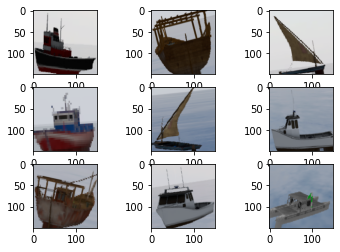

Found 78875 images belonging to 8 classes.
Found 223 images belonging to 8 classes.


In [5]:
for i in range(9):
    plt.subplot(330 + 1 + i)
    batch = train_generator.next()
    image = batch[0]
    plt.imshow(image[0])
plt.show()

train_generator, validation_generator = train_val_generators()

## Transfer learning - Create the pre-trained model

Download the `inception V3` weights into the `/tmp/` directory:

In [5]:
# Download the inception v3 weights
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2022-08-09 16:24:01--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.5.128, 64.233.167.128, 74.125.133.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.5.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  7.21MB/s    in 12s     

2022-08-09 16:24:13 (7.19 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



Now load the `InceptionV3` model and save the path to the weights you just downloaded:

In [6]:
# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model from the local pre-trained weights
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

Complete the `create_pre_trained_model` function below. You should specify the correct `input_shape` for the model (remember that you set a new resolution for the images instead of the native 300x300) and make all of the layers non-trainable:

In [7]:
# GRADED FUNCTION: create_pre_trained_model
def create_pre_trained_model(local_weights_file):
  ### START CODE HERE
  pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
                                  include_top = False, 
                                  weights = None) 

  pre_trained_model.load_weights(local_weights_file)

  # Make all the layers in the pre-trained model non-trainable
  for layer in pre_trained_model.layers[:249]:
    layer.trainable = False
  for layer in pre_trained_model.layers[249:]:
    layer.trainable = True

  ### END CODE HERE

  return pre_trained_model
  

Check that everything went well by comparing the last few rows of the model summary to the expected output:

In [8]:
pre_trained_model = create_pre_trained_model(local_weights_file)

# Print the model summary
pre_trained_model.summary()

2022-08-09 16:24:14.023999: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-09 16:24:14.074276: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-09 16:24:14.074360: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-09 16:24:14.074959: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compi

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

 batch_normalization_10 (BatchN  (None, 16, 16, 96)  288         ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 16, 16, 32)  96          ['conv2d_11[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_5 (Activation)      (None, 16, 16, 64)   0           ['batch_normalization_5[0][0]']  
                                                                                                  
 activation_7 (Activation)      (None, 16, 16, 64)   0           ['batch_normalization_7[0][0]']  
                                                                                                  
 activatio

 conv2d_20 (Conv2D)             (None, 16, 16, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_23 (Conv2D)             (None, 16, 16, 96)   55296       ['activation_22[0][0]']          
                                                                                                  
 batch_normalization_20 (BatchN  (None, 16, 16, 48)  144         ['conv2d_20[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_23 (BatchN  (None, 16, 16, 96)  288         ['conv2d_23[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

                                                                                                  
 conv2d_34 (Conv2D)             (None, 7, 7, 128)    98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_34 (BatchN  (None, 7, 7, 128)   384         ['conv2d_34[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_34 (Activation)     (None, 7, 7, 128)    0           ['batch_normalization_34[0][0]'] 
                                                                                                  
 conv2d_35 (Conv2D)             (None, 7, 7, 128)    114688      ['activation_34[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 activation_44 (Activation)     (None, 7, 7, 160)    0           ['batch_normalization_44[0][0]'] 
                                                                                                  
 conv2d_45 (Conv2D)             (None, 7, 7, 160)    179200      ['activation_44[0][0]']          
                                                                                                  
 batch_normalization_45 (BatchN  (None, 7, 7, 160)   480         ['conv2d_45[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_45 (Activation)     (None, 7, 7, 160)    0           ['batch_normalization_45[0][0]'] 
                                                                                                  
 conv2d_41

 batch_normalization_55 (BatchN  (None, 7, 7, 160)   480         ['conv2d_55[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 7, 7, 160)    0           ['batch_normalization_55[0][0]'] 
                                                                                                  
 conv2d_51 (Conv2D)             (None, 7, 7, 160)    122880      ['mixed5[0][0]']                 
                                                                                                  
 conv2d_56 (Conv2D)             (None, 7, 7, 160)    179200      ['activation_55[0][0]']          
                                                                                                  
 batch_normalization_51 (BatchN  (None, 7, 7, 160)   480         ['conv2d_51[0][0]']              
 ormalizat

 conv2d_61 (Conv2D)             (None, 7, 7, 192)    147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_66 (Conv2D)             (None, 7, 7, 192)    258048      ['activation_65[0][0]']          
                                                                                                  
 batch_normalization_61 (BatchN  (None, 7, 7, 192)   576         ['conv2d_61[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_66 (BatchN  (None, 7, 7, 192)   576         ['conv2d_66[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

 ormalization)                                                                                    
                                                                                                  
 batch_normalization_74 (BatchN  (None, 7, 7, 192)   576         ['conv2d_74[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_70 (Activation)     (None, 7, 7, 192)    0           ['batch_normalization_70[0][0]'] 
                                                                                                  
 activation_74 (Activation)     (None, 7, 7, 192)    0           ['batch_normalization_74[0][0]'] 
                                                                                                  
 conv2d_71 (Conv2D)             (None, 3, 3, 320)    552960      ['activation_70[0][0]']          
          

                                                                                                  
 activation_82 (Activation)     (None, 3, 3, 384)    0           ['batch_normalization_82[0][0]'] 
                                                                                                  
 activation_83 (Activation)     (None, 3, 3, 384)    0           ['batch_normalization_83[0][0]'] 
                                                                                                  
 batch_normalization_84 (BatchN  (None, 3, 3, 192)   576         ['conv2d_84[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_76 (Activation)     (None, 3, 3, 320)    0           ['batch_normalization_76[0][0]'] 
                                                                                                  
 mixed9_0 

 ormalization)                                                                                    
                                                                                                  
 activation_85 (Activation)     (None, 3, 3, 320)    0           ['batch_normalization_85[0][0]'] 
                                                                                                  
 mixed9_1 (Concatenate)         (None, 3, 3, 768)    0           ['activation_87[0][0]',          
                                                                  'activation_88[0][0]']          
                                                                                                  
 concatenate_1 (Concatenate)    (None, 3, 3, 768)    0           ['activation_91[0][0]',          
                                                                  'activation_92[0][0]']          
                                                                                                  
 activatio

**Expected Output:**
```
batch_normalization_v1_281 (Bat (None, 3, 3, 192)    576         conv2d_281[0][0]                 
__________________________________________________________________________________________________
activation_273 (Activation)     (None, 3, 3, 320)    0           batch_normalization_v1_273[0][0] 
__________________________________________________________________________________________________
mixed9_1 (Concatenate)          (None, 3, 3, 768)    0           activation_275[0][0]             
                                                                activation_276[0][0]             
__________________________________________________________________________________________________
concatenate_5 (Concatenate)     (None, 3, 3, 768)    0           activation_279[0][0]             
                                                                activation_280[0][0]             
__________________________________________________________________________________________________
activation_281 (Activation)     (None, 3, 3, 192)    0           batch_normalization_v1_281[0][0] 
__________________________________________________________________________________________________
mixed10 (Concatenate)           (None, 3, 3, 2048)   0           activation_273[0][0]             
                                                                mixed9_1[0][0]                   
                                                                concatenate_5[0][0]              
                                                                activation_281[0][0]             
==================================================================================================
Total params: 21,802,784
Trainable params: 0
Non-trainable params: 21,802,784


```

To check that all the layers in the model were set to be non-trainable, you can also run the cell below:

In [9]:
total_params = pre_trained_model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in pre_trained_model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 21,802,784 total parameters in this model.
There are 11,114,880 trainable parameters in this model.


**Expected Output:**
```
There are 21,802,784 total parameters in this model.
There are 0 trainable parameters in this model.
```

## Creating callbacks for later

You have already worked with callbacks in the first course of this specialization so the callback to stop training once an accuracy of 99.9% is reached, is provided for you:

In [10]:
# Define a Callback class that stops training once accuracy reaches 99.9%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.9999):
      print("\nReached 99.99% accuracy so cancelling training!")
      self.model.stop_training = True

## Pipelining the pre-trained model with your own

Now that the pre-trained model is ready, you need to "glue" it to your own model to solve the task at hand.

For this you will need the last output of the pre-trained model, since this will be the input for your own. Complete the `output_of_last_layer` function below.

**Note:** For grading purposes use the `mixed7` layer as the last layer of the pre-trained model. However, after submitting feel free to come back here and play around with this.

In [11]:
# GRADED FUNCTION: output_of_last_layer
def output_of_last_layer(pre_trained_model):
  ### START CODE HERE
  last_desired_layer = pre_trained_model.get_layer(name = 'mixed7')
  print('last layer output shape: ', last_desired_layer.output_shape)
  last_output = last_desired_layer.output
  print('last layer output: ', last_output)
  ### END CODE HERE

  return last_output


Check that everything works as expected:

In [12]:
last_output = output_of_last_layer(pre_trained_model)

last layer output shape:  (None, 7, 7, 768)
last layer output:  KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 768), dtype=tf.float32, name=None), name='mixed7/concat:0', description="created by layer 'mixed7'")


**Expected Output (if `mixed7` layer was used):**
```
last layer output shape:  (None, 7, 7, 768)
last layer output:  KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 768), dtype=tf.float32, name=None), name='mixed7/concat:0', description="created by layer 'mixed7'")
```

Now you will create the final model by adding some additional layers on top of the pre-trained model.

Complete the `create_final_model` function below. You will need to use Tensorflow's [Functional API](https://www.tensorflow.org/guide/keras/functional) for this since the pretrained model has been created using it. 

Let's double check this first:

In [13]:
# Print the type of the pre-trained model
print(f"The pretrained model has type: {type(pre_trained_model)}")

The pretrained model has type: <class 'keras.engine.functional.Functional'>


To create the final model, you will use Keras' Model class by defining the appropriate inputs and outputs as described in the first way to instantiate a Model in the [docs](https://www.tensorflow.org/api_docs/python/tf/keras/Model).

Note that you can get the input from any existing model by using its `input` attribute and by using the Funcional API you can use the last layer directly as output when creating the final model.

In [14]:
# GRADED FUNCTION: create_final_model
def create_final_model(pre_trained_model, last_output):
  # Flatten the output layer to 1 dimension
  x = layers.Flatten()(last_output)

  ### START CODE HERE

  # Add a fully connected layer with 1024 hidden units and ReLU activation
  x = layers.Dense(1024, activation = 'relu')(x)
  # Add a dropout rate of 0.2
  x = layers.Dropout(0.2)(x)
  
  x = layers.Dense(8, activation = 'softmax')(x)        

  # Create the complete model by using the Model class
  model = Model(inputs=pre_trained_model.input, outputs=x)

  # Compile the model
  model.compile(optimizer = RMSprop(learning_rate=0.0001), 
                loss = 'categorical_crossentropy',
                metrics = ['accuracy'])

  ### END CODE HERE
  
  return model


In [15]:
# Save your model in a variable
model = create_final_model(pre_trained_model, last_output)

# Inspect parameters
total_params = model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 47,519,656 total parameters in this model.
There are 38,544,392 trainable parameters in this model.


**Expected Output:**
```
There are 47,512,481 total parameters in this model.
There are 38,537,217 trainable parameters in this model.
```

Wow, that is a lot of parameters!

After submitting your assignment later, try re-running this notebook but use the original resolution of 300x300, you will be surprised to see how many more parameters are for that case.

Now train the model:

In [16]:
# Run this and see how many epochs it should take before the callback
# fires, and stops training at 99.9% accuracy
# (It should take a few epochs)
callbacks = myCallback()

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = 100,
                    verbose = 2,
                    callbacks=[callbacks,tensorboard_callback])

Epoch 1/100


2022-08-09 16:24:18.498031: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2022-08-09 16:24:20.455025: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


626/626 - 211s - loss: 0.0236 - accuracy: 0.9935 - val_loss: 4.1108e-07 - val_accuracy: 1.0000 - 211s/epoch - 337ms/step
Epoch 2/100
626/626 - 201s - loss: 4.0879e-04 - accuracy: 0.9999 - val_loss: 3.4747e-08 - val_accuracy: 1.0000 - 201s/epoch - 322ms/step
Epoch 3/100

Reached 99.99% accuracy so cancelling training!
626/626 - 181s - loss: 2.0665e-05 - accuracy: 1.0000 - val_loss: 3.7420e-09 - val_accuracy: 1.0000 - 181s/epoch - 289ms/step


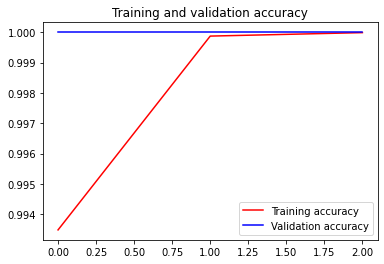

<Figure size 432x288 with 0 Axes>

In [17]:
# Plot the training and validation accuracies for each epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

You will need to submit this notebook for grading. To download it, click on the `File` tab in the upper left corner of the screen then click on `Download` -> `Download .ipynb`. You can name it anything you want as long as it is a valid `.ipynb` (jupyter notebook) file.

In [18]:
model.save('saved_model/Boats7')

INFO:tensorflow:Assets written to: saved_model/Boats7/assets


INFO:tensorflow:Assets written to: saved_model/Boats7/assets
